In [1]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt

# NB!!! For alle dyp

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dv = xr.open_zarr(store=store2, consolidated=True)
dzz = xr.open_zarr(store=store3, consolidated=True)

In [3]:
dv

<xarray.Dataset>
Dimensions:        (depth: 75, t: 1, time_counter: 73, x: 1200, y: 900)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: t, x, y
Data variables:
    mbathy         (t, y, x) int16 dask.array<chunksize=(1, 900, 1200), meta=np.ndarray>
    vel            (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vomecrty       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
    vozocrtx       (time_counter, depth, y, x) float32 dask.array<chunksize=(1, 75, 900, 1200), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [4]:
d = dv.mbathy.squeeze(axis=0)
u = dv.vozocrtx
v = dv.vomecrty
vel = np.sqrt(u**2 + v**2)

In [5]:
punkt_list = [(503,502), (638,300), (871,602), (820,200), (520,350)]

503 502
638 300
871 602
820 200
520 350


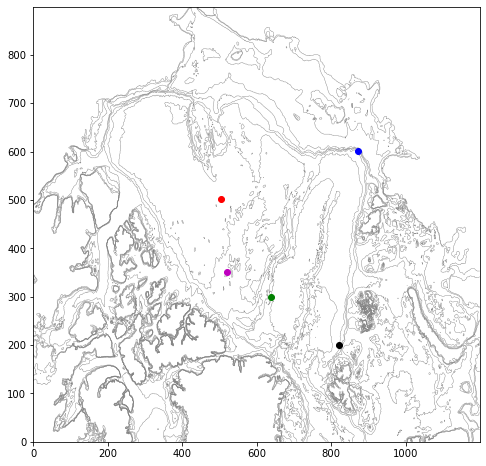

In [6]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
c_list = ['r', 'g', 'b', 'k', 'm']
axs.contour(d, colors = 'grey', levels=8, linewidths=0.4)

for p in range(len((punkt_list))):
    
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])

## With surface currents 

In [13]:
u

<xarray.DataArray 'vozocrtx' (time_counter: 73, depth: 75, y: 900, x: 1200)>
dask.array<xarray-vozocrtx, shape=(73, 75, 900, 1200), dtype=float32, chunksize=(1, 75, 900, 1200), chunktype=numpy.ndarray>
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) object 2000-01-03 12:00:00 ... 2000-12-29 1...
Dimensions without coordinates: y, x
Attributes:
    cell_methods:        time: mean (interval: 360 s)
    coordinates:         time_centered depthu nav_lat nav_lon
    interval_operation:  360 s
    interval_write:      5 d
    long_name:           sea_water_x_velocity
    online_operation:    average
    standard_name:       sea_water_x_velocity
    units:               m/s

In [12]:
'Weigthing the levels'
z = dzz.gdept_1d.isel(t=0)
dz = np.gradient(z)

array([  1.05009529,   1.08096087,   1.15021222,   1.23633975,
         1.34337694,   1.47607857,   1.63985841,   1.84058055,
         2.08414379,   2.37582103,   2.71938237,   3.11614733,
         3.56424907,   4.0584728 ,   4.5909519 ,   5.15273147,
         5.73584469,   6.33530623,   6.95047306,   7.58552332,
         8.24916078,   8.95387075,   9.71507541,  10.55042777,
        11.47934426,  12.52277076,  13.70312195,  15.04431701,
        16.57183864,  18.31275194,  20.29562892,  22.5503307 ,
        25.10760333,  27.99844685,  31.25322382,  34.90048453,
        38.96550552,  43.46856645,  48.42302908,  53.8333281 ,
        59.69303345,  65.98318708,  72.67114424,  79.7101473 ,
        87.03981906,  94.58767976, 102.27167396, 110.00355756,
       117.69286769, 125.25110628, 132.59573329, 139.65359654,
       146.36351399, 152.6778505 , 158.56306727, 163.99934159,
       168.9794399 , 173.50707026, 177.5949446 , 181.26275534,
       184.53522761, 187.44035895, 190.00791127, 192.26

In [33]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'
    
    up = u.isel(x=x, y=y)*np.sqrt(dz)
    dp = d.isel(x=x, y=y).values

    dyp = up.isel(depth = slice(0,dp-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    val_ = values*(1/np.sqrt(dz[:dp-1]))
    vec_ = vectors*(1/np.sqrt(dz[:dp-1]))
    
    return  val_, vec_, dyp

503 502
638 300
871 602
820 200
520 350


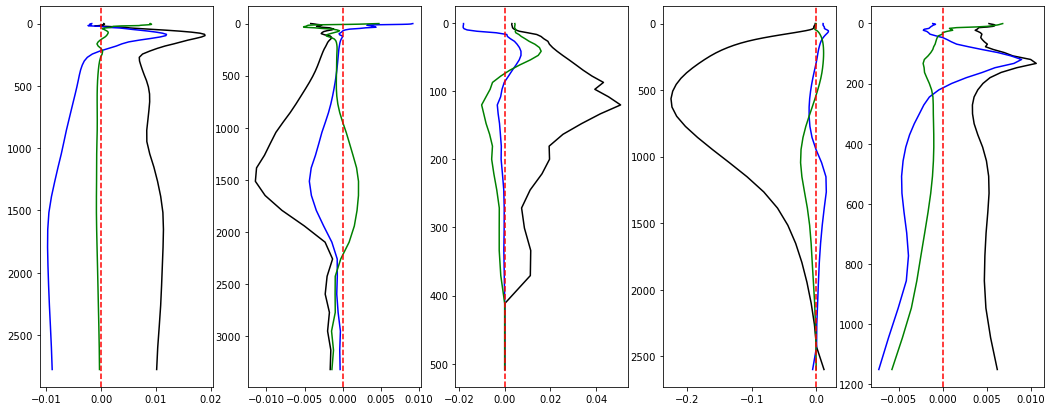

In [34]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

NameError: name 'values' is not defined

## Skipping the 10 first m 

In [143]:
def PCz_10(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(8,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


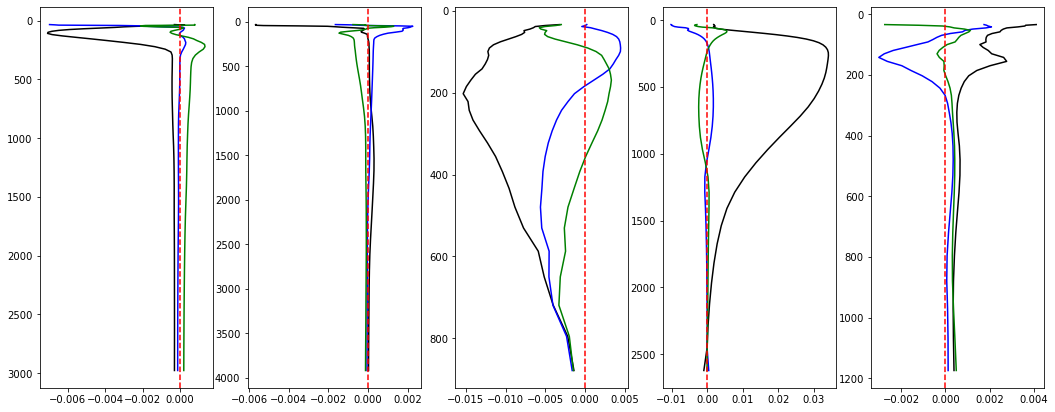

In [144]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_10(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()


## Skipping for first 20m

In [ ]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


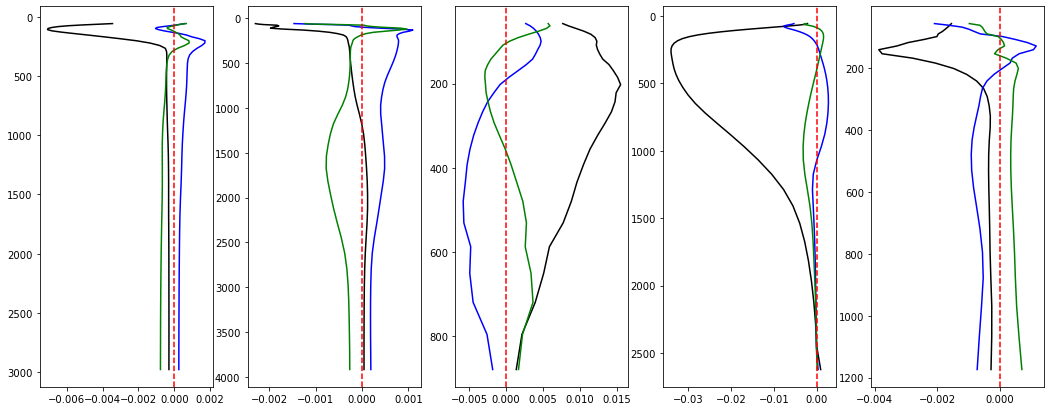

In [99]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()


## Skipping the first 41m 

In [100]:
def PCz_19(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(19,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


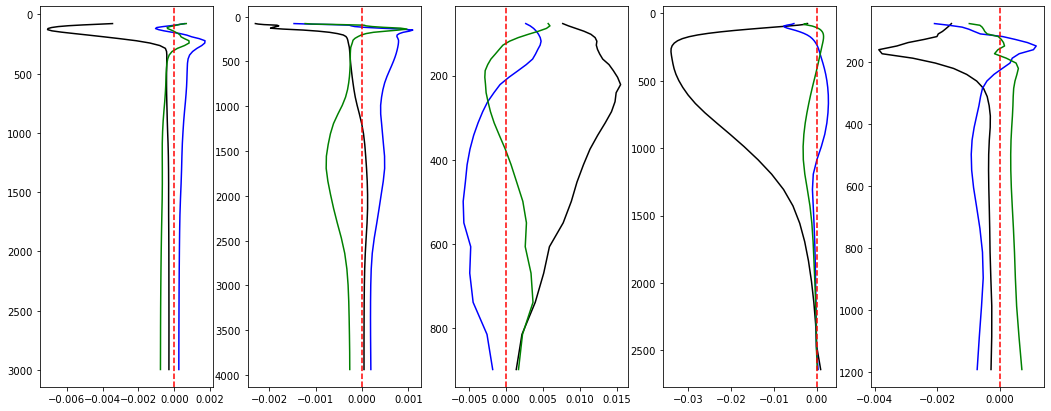

In [101]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+41, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+41, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+41, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()
